In [12]:
#Libraries
using Gen
using PyPlot
using Distributions
using LinearAlgebra
using Flux
using Random
using Distances
using JLD
using StatsBase
include("hmc_mod.jl")
include("helper_functions.jl")
include("rj_proposals_layers.jl")
include("NUTS_CS.jl");

In [20]:
#---------------------------
#Load Boston Housing Dataset
#---------------------------
data = load("boston.jld")["boston"]

# Generating test/training sets:
nrow, ncol = size(data)
nrow_test  = div(nrow, 3)
nrow_train = nrow - nrow_test

x = data[:,1:13]
y = data[:,14]
y_raw = y

dx = fit(ZScoreTransform, x, dims=1)
StatsBase.transform!(dx, x)
dy = fit(ZScoreTransform, y; dims=1)
StatsBase.transform!(dy, y);

x_raw = x
x = transpose(x)

#------------------------------------
#Hyperparameters and Helper Functions
#------------------------------------

#Select Network Goal
#network = "classifier"
network = "interpolator"

#Data hyperparameters
n = nrow #Number of samples per mode (classifier)
d = ncol-1 #Input dimension

#Network hyperparameters
k_real = 8 #Number of hidden nodes per layer
k_vector = [0.0 for i=1:k_real]
k_vector[k_real] = 1.0

#Layer hyperparameters
l_range = 4 #Maximum number of layers in the network
l_list = [Int(i) for i in 1:l_range]
l_real = 1;

0.9909091038823534
8.226594938153747
0.02324687503694227


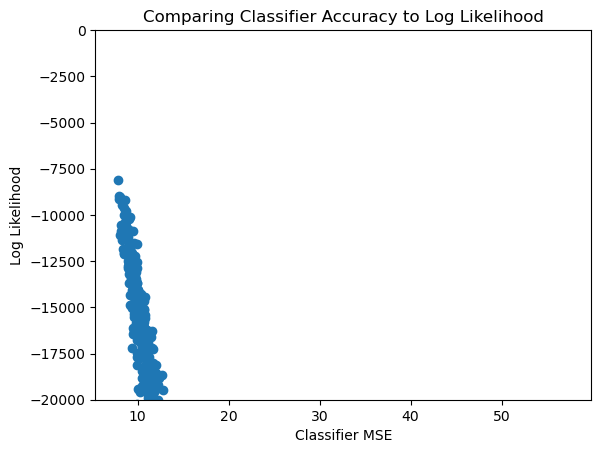

Best MSE: 7.832880374602084


In [69]:
#Bayesian Neural Net
function G(x, trace)
    activation = sigmoid
    layers = trace[:l]
    ks = [trace[(:k,i)] for i=1:layers]
    for i=1:layers
        in_dim, out_dim = layer_unpacker(i, layers, ks)
        W = reshape(trace[(:W,i)], out_dim, in_dim)
        b = reshape(trace[(:b,i)], trace[(:k,i)])
        nn = Dense(W, b, activation)
        x = nn(x)
    end
    
    Wₒ = reshape(trace[(:W,layers+1)], 1, ks[layers])
    bₒ = reshape(trace[(:b,layers+1)], 1)
    
    nn_out = Dense(Wₒ, bₒ)
    return nn_out(x)
end;

@gen function interpolator(x)
    
    #Create a blank choicemap
    obs = choicemap()::ChoiceMap
    
    #Draw number of layers
    l ~ categorical([1/length(l_list) for i=1:length(l_list)])
    l_real = l
    obs[:l] = l
    
    #Create individual weight and bias vectors
    #Loop through hidden layers
    k = [Int(0) for i=1:l+1]
    for i=1:l
        k[i] = @trace(categorical(k_vector), (:k,i))
        obs[(:k,i)] = k[i]
    end
    k[l+1] = @trace(categorical([1.0]), (:k,l+1))
    obs[(:k,l+1)] = k[l+1]
    
    ######################################
    #New hyperparameter schedule - Jan 20#
    ######################################
    
    #Standard Deviations
    τ₁ ~ gamma(100,0.01) #(100,0.01) Hidden weights and biases
    τ₂ ~ gamma(100*k[1],0.01) #(100*k,0.01) Output weights and biases
    τᵧ ~ gamma(100, 0.5) #(100,0.5)
    σ₁ = 1/τ₁
    σ₂ = 1/τ₂
    σᵧ = 1/τᵧ
    
    #Sample weight and bias vectors
    W = [zeros(k[i]) for i=1:l+1]
    b = [zeros(k[i]) for i=1:l+1]
    μ = [zeros(k[i]) for i=1:l+1]
    μb = [zeros(k[i]) for i=1:l+1]

    for i=1:l+1
        if i == 1
            h = Int(d * k[i])
        else
            h = Int(k[i-1] * k[i])
        end

        if i<=l
            #Hidden Weights
            u = zeros(h) #Draw
            S = Diagonal([1 for i=1:length(u)])
            μ[i] = @trace(mvnormal(u,S), (:μ,i))
            Σ = Diagonal([σ₁ for i=1:length(μ[i])])
            W[i] = @trace(mvnormal(μ[i],Σ), (:W,i))
            obs[(:W,i)] = W[i]
            
            #Hidden Biases
            ub = zeros(k[i]) #Draw
            Sb = Diagonal([1 for i=1:length(ub)])    
            μb[i] = @trace(mvnormal(ub,Sb), (:μb,i))
            Σ2 = Diagonal([σ₁ for i=1:length(μb[i])])
            b[i] = @trace(mvnormal(μb[i],Σ2), (:b,i))
            obs[(:b,i)] = b[i]
        else
            #Output Weights
            u = zeros(k[l]) #Draw
            S = Diagonal([1 for i=1:length(u)])
            μ[i] = @trace(mvnormal(u,S), (:μ,i))
            Σ = Diagonal([σ₂ for i=1:length(μ[i])])
            W[i] = @trace(mvnormal(μ[i],Σ), (:W,i))
            obs[(:W,i)] = W[i]

            #Output Bias
            ub = zeros(1) #Draw
            Sb = Diagonal([1 for i=1:length(ub)])  
            μb[i] = @trace(mvnormal(ub,Sb), (:μb,i))
            Σ2 = Diagonal([σ₂ for i=1:length(μb[i])])
            b[i] = @trace(mvnormal(μb[i],Σ2), (:b,i))
            obs[(:b,i)] = b[i]
        end
    end
    
    #Return Network Scores for X
    scores = transpose(G(x,obs))[:,1]
    #scores = Flux.tanh.(scores)
    
    #Regression Likelihood
    y = @trace(mvnormal(vec(scores), Diagonal([σᵧ for i=1:length(x[1,:])])), (:y))

    return scores
    
end;

#Register Observed Data - Bernoulli
obs_master = choicemap()::ChoiceMap
obs_master[:y] = y
obs = obs_master;

(best_trace,) = generate(interpolator, (x,), obs)
println(best_trace[:τ₁])
println(best_trace[:τ₂])
println(1 / best_trace[:τᵧ])

test_scores = interpolator(x)
test2 = StatsBase.reconstruct(dy, test_scores)
mse_scaled(test_scores, y)

#----------------
#Test Likelihood
#----------------
best_trace, scores, mses = likelihood_regression(1000)
PyPlot.scatter(mses, scores)
plt.title("Comparing Classifier Accuracy to Log Likelihood")
plt.xlabel("Classifier MSE")
plt.ylabel("Log Likelihood")
plt.ylim(-20000,1)
#plt.xlim(0,2000)
#plt.legend()

pred_y = G(x,best_trace)
pred_y = transpose(pred_y)[:,1]
best_mse = mse_scaled(pred_y, y)
println("Best MSE: $best_mse")

In [46]:
#----------------
#Fixed NUTS Test
#----------------

Δ_max = 10000
obs[:l] = 1
(trace,) = generate(interpolator, (x,), obs)
trace = best_trace
param_selection = select()

for i=1:obs[:l]+1 #Number of Layers
    push!(param_selection, (:μ,i))
    push!(param_selection, (:μb,i))
    push!(param_selection, (:W,i))
    push!(param_selection, (:b,i))
end

traces = NUTS(trace, param_selection, 0.55, 3000, 3, true);

[NUTS] start sampling for 3000 samples with inital ϵ=1
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

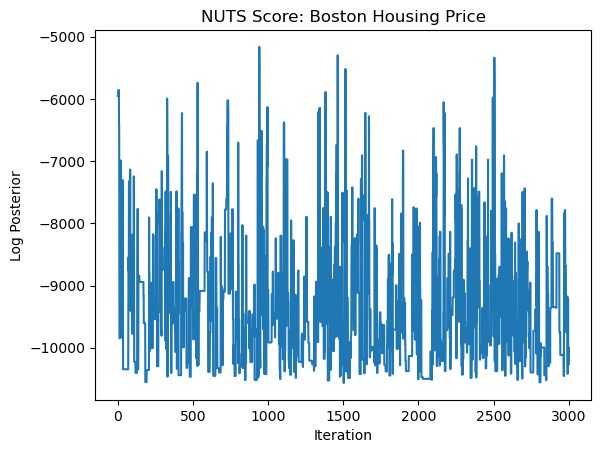

In [47]:
#-----------------------------------
#Plot Log Posterior Scores by Trace
#-----------------------------------

plot([get_score(trace) for trace in traces])
plt.title("NUTS Score: Boston Housing Price")
plt.xlabel("Iteration")
plt.ylabel("Log Posterior");

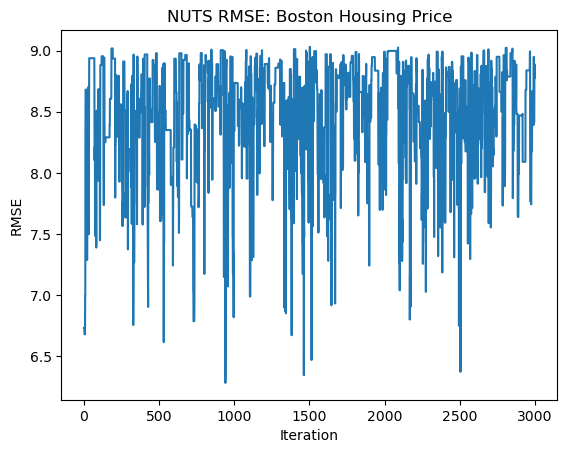

In [48]:
#-------------------------
#Plot RMSE Scores by Trace
#-------------------------

mses = []
for i=1:length(traces)
    trace = traces[i]
    pred_y = G(x,trace)
    pred_y = transpose(pred_y)[:,1]
    mse = mse_scaled(pred_y,y)

    push!(mses,mse)
end

plot(mses)
plt.title("NUTS RMSE: Boston Housing Price")
plt.xlabel("Iteration")
plt.ylabel("RMSE");

best_trace = traces[1]
for i=1:length(traces)
    if get_score(traces[i]) > get_score(best_trace)
        best_trace = traces[i]
    end
end

In [49]:
#---------------
#Marginalize MSE
#---------------
j = 100
y_marginal = zeros(length(y))

for i=j:length(traces)
    trace = traces[i]
    pred_y = G(x,trace)
    pred_y = transpose(G(x,trace))[:,1]
    y_marginal += (pred_y/(length(traces)-j))
end

display(y_marginal[1:5])
display(y[1:5])

mse = mse_scaled(y_marginal, y_raw)

7.30654389351966

In [62]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%#
#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$#
############NUTS SAMPLING#############
#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$#
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%#

include("NUTS_CS.jl")
Δ_max = 10000
Random.seed!(4)

scores = []
traces = []
ks = []
across_acceptance = []
within_acceptance = []
hyper1_acceptance = []
hyper2_acceptance = []

#HMC Hyperparameters
iters = 1
m = 3

function propose_hyperparameters(trace)
    
    hyper_selection = select()
    push!(hyper_selection, :τ₁)
    push!(hyper_selection, :τ₂)
    push!(hyper_selection, :τᵧ)
    (new_trace, weight, retdiff) = regenerate(trace, hyper_selection)
    
    if log(rand()) < weight
        return (new_trace, 1)
    else
        return (trace, 0)
    end
end;

function nuts_parameters(trace)
    
    l = trace[:l]
    param_selection = select()
    for i=1:l+1 #Number of Layers
        #push!(param_selection, (:μ,i))
        #push!(param_selection, (:μb,i))
        push!(param_selection, (:W,i))
        push!(param_selection, (:b,i))
    end
    
    prev_score = get_score(trace)
    
    acc = 0
    for i=1:iters
        new_trace = NUTS(trace, param_selection, 0.65, m, m, false)[m+1]
        new_score = get_score(new_trace)
        if prev_score != new_score
            return (new_trace, 1)
        else
            return (trace, 0)
        end
    end
    
    return (trace, acc)
end

function nuts_hyperparameters2(trace)
    
    l = trace[:l]
    hyper2_selection = select()
    for i=1:l+1 #Number of Layers
        push!(hyper2_selection, (:μ,i))
        push!(hyper2_selection, (:μb,i))
    end
    
    prev_score = get_score(trace)
    new_trace = NUTS(trace, hyper2_selection, 0.65, m, m, false)[m+1]
    new_score = get_score(new_trace)
    weight = new_score - prev_score
    #println(weight)
    
    #(new_trace, weight, retdiff) = regenerate(trace, hyper2_selection)
    
    #if log(rand()) < weight
    #    return (new_trace, 1)
    #else
    #    return (trace, 0)
    #end
    
    if prev_score != new_score
        return (new_trace, 1)
    else
        return (trace, 0)
    end
    
end

function node_parameter(trace)
    obs = obs_master
    
    init_trace = trace
    
    #################################################RJNUTS#################################################
    #HMC Step 1
    trace_tilde = trace
    for i=1:iters
        (trace_tilde,) = propose_hyperparameters(trace_tilde)
        (trace_tilde,) = nuts_hyperparameters2(trace_tilde)
        (trace_tilde,) = nuts_parameters(trace_tilde)
        #(trace_tilde, accepted) = hmc(trace_tilde,param_selection,L=leap,eps=ϵ,check=false,observations=obs)
    end
    #Reversible Jump Step
    (trace_prime, q_weight) = layer_change(trace_tilde)
    #HMC Step 2
    trace_star = trace_prime
    for i=1:iters
        #(trace_star, accepted) = hmc(trace_star,param_selection,L=leap,eps=ϵ,check=false,observations=obs)
        (trace_star,) = nuts_parameters(trace_star)
        (trace_star,) = nuts_hyperparameters2(trace_star)
        (trace_star,) = propose_hyperparameters(trace_star) 
    end
    #################################################RJNUTS#################################################
        
    model_score = -get_score(init_trace) + get_score(trace_star)
    across_score = model_score + q_weight
    #println(across_score)
    #println(model_score)

    if rand() < exp(across_score)
        println("********** Accepted: $(trace_star[:l]) **********")
        return (trace_star, 1)
    else
        return (init_trace, 0)
    end
end

(trace,) = generate(interpolator, (x,), obs)
#trace = best_trace

for i=1:500
    (trace, accepted) = node_parameter(trace)
    push!(across_acceptance, accepted)
    (trace, accepted)  = propose_hyperparameters(trace)
    push!(hyper1_acceptance, accepted)
    (trace, accepted)  = nuts_hyperparameters2(trace)
    push!(hyper2_acceptance, accepted)
    (trace, accepted)  = nuts_parameters(trace)
    push!(within_acceptance, accepted)
    push!(scores,get_score(trace))
    push!(traces, trace)
    println("$i : $(get_score(trace))")
    if i%10 == 0
        a_acc = 100*(sum(across_acceptance)/length(across_acceptance))
        w_acc = 100*(sum(within_acceptance)/length(within_acceptance))
        h_acc = 100*(sum(hyper1_acceptance)/length(hyper1_acceptance))
        h2_acc = 100*(sum(hyper2_acceptance)/length(hyper2_acceptance))
        println("Epoch $i A Acceptance Probability: $a_acc %")
        println("Epoch $i W Acceptance Probability: $w_acc %")
        println("Epoch $i H Acceptance Probability: $h_acc %")
        println("Epoch $i H2 Acceptance Probability: $h2_acc %")
    end
end

********** Accepted: 2 **********
1 : -59643.21753696128
2 : -59643.21753696128
3 : -57877.73058529242
4 : -57877.73058529242
5 : -57877.73058529242
6 : -52259.72228456172
7 : -52259.72228456172
8 : -52259.72228456172
9 : -52259.72228456172
10 : -52259.72228456172
Epoch 10 A Acceptance Probability: 10.0 %
Epoch 10 W Acceptance Probability: 0.0 %
Epoch 10 H Acceptance Probability: 20.0 %
Epoch 10 H2 Acceptance Probability: 0.0 %
11 : -52259.72228456172
12 : -52259.72228456172
********** Accepted: 3 **********
13 : -49246.96325771464
14 : -49246.96325771464
********** Accepted: 4 **********
15 : -26642.72142363493
16 : -26642.72142363493
17 : -26642.72142363493
18 : -26642.72142363493
19 : -26642.72142363493
20 : -26642.72142363493
Epoch 20 A Acceptance Probability: 15.0 %
Epoch 20 W Acceptance Probability: 0.0 %
Epoch 20 H Acceptance Probability: 10.0 %
Epoch 20 H2 Acceptance Probability: 0.0 %
21 : -26642.72142363493
22 : -10172.023901311126
23 : -10459.192696690616
24 : -10465.1301636

181 : -10181.713080019326
182 : -10155.267449270414
183 : -10043.698817499855
184 : -10008.661142785702
185 : -9964.104301353189
186 : -9986.862537127796
187 : -10015.603548810172
188 : -10018.700863826756
189 : -10059.695074267747
190 : -10063.582084710102
Epoch 190 A Acceptance Probability: 4.736842105263158 %
Epoch 190 W Acceptance Probability: 6.842105263157896 %
Epoch 190 H Acceptance Probability: 1.5789473684210527 %
Epoch 190 H2 Acceptance Probability: 87.89473684210526 %
191 : -10022.318189102196
192 : -10000.150818921933
193 : -9967.742014654557
194 : -10137.206567313304
********** Accepted: 3 **********
195 : -10204.87485790174
********** Accepted: 4 **********
196 : -10368.444449853045
********** Accepted: 3 **********
197 : -10296.599743704235
198 : -10572.385736197864
199 : -10305.488816591533
********** Accepted: 2 **********
200 : -8930.45494466201
Epoch 200 A Acceptance Probability: 6.5 %
Epoch 200 W Acceptance Probability: 6.5 %
Epoch 200 H Acceptance Probability: 1.5 

351 : -8390.009771124925
352 : -8370.07090059866
353 : -8409.885719603168
354 : -8436.374864684656
355 : -8348.938530464482
356 : -10493.756201321787
357 : -10551.92462518213
358 : -10575.424450779386
359 : -10599.473264312048
********** Accepted: 3 **********
360 : -10142.153503250851
Epoch 360 A Acceptance Probability: 5.555555555555555 %
Epoch 360 W Acceptance Probability: 5.0 %
Epoch 360 H Acceptance Probability: 1.1111111111111112 %
Epoch 360 H2 Acceptance Probability: 93.61111111111111 %
361 : -10226.897987206845
362 : -10183.12451058817
363 : -10505.516219444755
364 : -10307.363439671404
365 : -10265.89192611429
366 : -10246.746834646061
********** Accepted: 4 **********
367 : -10431.915943449536
********** Accepted: 3 **********
368 : -10221.222328625001
369 : -10288.270461305521
370 : -10567.673355371313
Epoch 370 A Acceptance Probability: 5.9459459459459465 %
Epoch 370 W Acceptance Probability: 4.864864864864865 %
Epoch 370 H Acceptance Probability: 1.0810810810810811 %
Epoch

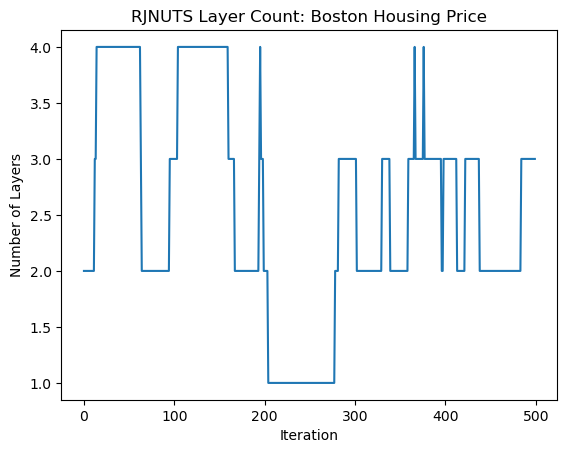

In [63]:
#-----------
#Layers Plot
#-----------

layers = [trace[:l] for trace in traces]
plot(layers)
plt.title("RJNUTS Layer Count: Boston Housing Price")
plt.xlabel("Iteration")
plt.ylabel("Number of Layers");

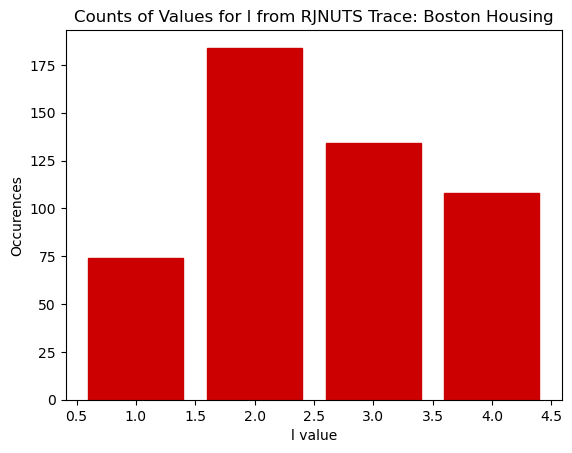

In [64]:
########################
#Bar Plot of l estimates
########################

ls = [traces[i][:l] for i in 1:length(traces)]
counts = [sum([ls[i] == j for i in 1:length(ks)]) for j in l_list]

barlist=bar(l_list,counts)
for i in 1:l_range
    barlist[i].set_color([0.8,0.0,0.0])
end
#barlist[2].set_color([0.0,0.8,0.1])

plt.title("Counts of Values for l from RJNUTS Trace: Boston Housing")
plt.xlabel("l value")
plt.ylabel("Occurences");

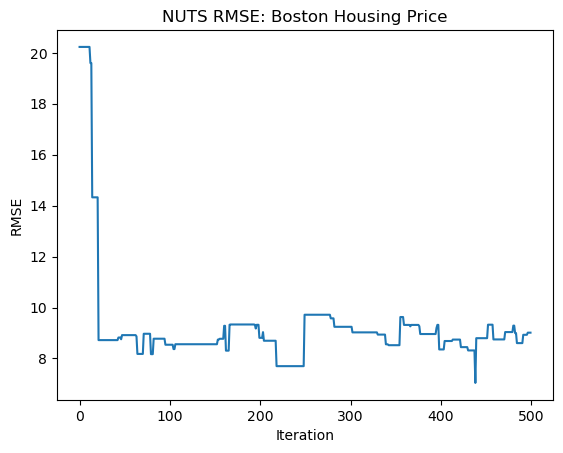

In [65]:
#-------------------------
#Plot RMSE Scores by Trace
#-------------------------

mses = []
for i=1:length(traces)
    trace = traces[i]
    pred_y = G(x,trace)
    pred_y = transpose(pred_y)[:,1]
    mse = mse_scaled(pred_y,y)

    push!(mses,mse)
end

plot(mses)
plt.title("NUTS RMSE: Boston Housing Price")
plt.xlabel("Iteration")
plt.ylabel("RMSE");

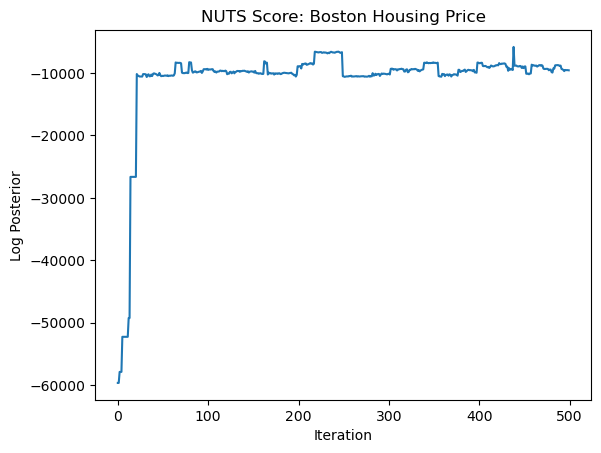

In [66]:
#-----------------------------------
#Plot Log Posterior Scores by Trace
#-----------------------------------

plot([get_score(trace) for trace in traces])
plt.title("NUTS Score: Boston Housing Price")
plt.xlabel("Iteration")
plt.ylabel("Log Posterior");

In [68]:
#---------------
#Marginalize MSE
#---------------
j = 100
y_marginal = zeros(length(y))

for i=j:length(traces)
    trace = traces[i]
    pred_y = transpose(G(x,trace))[:,1]
    y_marginal += (pred_y/(length(traces)-j))
end

display(y_marginal[1:5])
display(y[1:5])

mse = mse_scaled(y_marginal, y_raw)

5-element Array{Float64,1}:
 0.31346133757722017
 0.1505924407826844
 0.3457147934386521
 0.28084018053020326
 0.2401811662380366

5-element Array{Float64,1}:
  0.15952778852449834
 -0.10142391727311864
  1.3229374768722084
  1.181588636231832
  1.486032292995719

7.683761901895173

In [ ]:
#--------------------
#RJMCMC - using HMC
#--------------------
traces = []
scores = []
acc = []
acc_l = []
acc_w = []
l_results = []
epss = []
l = 10
ϵ = 0.001

function within_move(trace, iters, obs, prev_trace)
    selection = select_selection(trace)
    score1 = get_score(prev_trace)
    (new_trace, hmc_score) = hmc_mod(trace, selection, L=l, eps=ϵ, check=false, observations=obs)
    
    score2 = get_score(new_trace)
    #println("new trace score: $score2")
    #println("old trace score: $score1")
    acc_score = score2 - score1
    #println("Calc score: $acc_score")
    #println("hmc_score: $hmc_score")
    if rand(Uniform(0,1)) < exp(hmc_score)
        trace = new_trace
        accepted = 1.0
        #println("Accepted")
    else
        trace = prev_trace
        accepted = 0.0
        #println("Not Accepted")
    end
    #push!(traces, trace)
    push!(acc, accepted)
    push!(acc_w, accepted)
    #accepted && println("Within accepted")
    return trace
end

function rjmcmc(starting_trace, iters)
    trace = starting_trace
    l = trace[:l]
    ks = [trace[(:k,i)] for i=1:trace[:l]]
    println("Beginning RJMCMC")
    println("Starting ks: $ks")
    println("--------------------------------")

    for i=1:iters
        l = trace[:l]
        obs = obs_master;
        if i%50 == 0
            #println("Epoch $i Acceptance Prob: $(sum(acc)/length(acc))")
            #println("Epoch $i layer count: $l, ks: $ks")
            println("Epoch $i Within Acceptance Prob: $(sum(acc_w)/length(acc_w))")
            #println("Epoch $i Layer Acceptance Prob: $(sum(acc_l)/length(acc_l))")
            #println([trace[(:k,i)] for i=1:trace[:l]])
        end
        
        #Gibbs sampling for hyperparameters
        prev_trace = trace
        trace, obs = select_hyperparameters(prev_trace, obs)
        
        #Indicator variable for move type
        u = rand(Uniform(0,1))
        if u > 1.0
            (trace) = layer_move(trace, 3, obs, prev_trace)
        else
            (trace) = within_move(trace, 10, obs, prev_trace)
        end
        push!(traces, trace)
        push!(scores, get_score(trace))
        push!(l_results, trace[:l])
    end
    println("Finished")
end
 
runs = 2000

obs_master = choicemap()::ChoiceMap
obs_master[:y] = y
obs_master[:l] = 4
obs = obs_master;
(starting_trace,) = generate(interpolator, (x,), obs)
#starting_trace = best_trace

include("NUTS.jl");
rjmcmc(starting_trace,runs);